acousticness - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
<p/>
danceability - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
<p/>
energy - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
<p/>
instrumentalness - Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
<p/>
liveness - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
<p/>
loudness - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
<p/>
speechiness - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
<p/>
valence - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
<p/>
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

datapath = '../Data/'

In [2]:
def load_playlist(playlist='saved_tracks.h5'):
    df_playlist = pd.read_hdf(datapath + playlist, key='df')
    df_playlist.drop(['analysis_url', 'track_href', 'uri', 'type'], axis=1, inplace=True)
    df_playlist['added_at'] = df_playlist['added_at'].apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
    df_playlist['added_year'] = df_playlist['added_at'].apply(lambda x : x.year)
    df_playlist['added_month'] = df_playlist['added_at'].apply(lambda x : x.month)
    df_playlist['tempo_01'] = df_playlist['tempo'] / df_playlist['tempo'].max()
    return df_playlist

In [3]:
df_saved = load_playlist()

In [4]:
df_saved.sample(5)

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,added_at,song_title,artists,added_year,added_month,tempo_01
9,0.2530,0.612,211360,0.875,3IyeQMpMEqNcEvFQGJ2eps,0.000000,1,0.4230,-6.032,1,0.3510,99.882,4,0.823,2015-12-19 07:12:44,Focus,Ariana Grande,2015,12,0.494213
3,0.2090,0.771,270405,0.488,6sevdfuPDZHCP4yR8F6kAv,0.044500,10,0.0726,-7.978,0,0.0473,91.031,4,0.568,2015-11-21 04:59:53,Instant Need,FKJ,2015,11,0.450419
4,0.5470,0.648,230540,0.250,2qJ8cB0YZSpr6Tp0a0dkB3,0.000015,6,0.2680,-11.989,0,0.2740,127.675,4,0.183,2016-12-06 14:36:42,Yours,SG Lewis,2016,12,0.631732
15,0.0225,0.533,230813,0.677,219eUQBWnfmADjKZEWEfSM,0.000006,6,0.2640,-3.912,0,0.0367,135.948,4,0.210,2016-02-06 08:43:29,Who You Are,Jessie J,2016,2,0.672667
0,0.9870,0.624,242787,0.165,319uC8bZ9eq3qmj1xzCXs4,0.889000,0,0.1340,-17.123,1,0.0588,123.742,4,0.250,2017-10-15 09:28:15,Theme Of Mitsuha,RADWIMPS,2017,10,0.612272


In [5]:
print(df_saved.shape)

(446, 20)


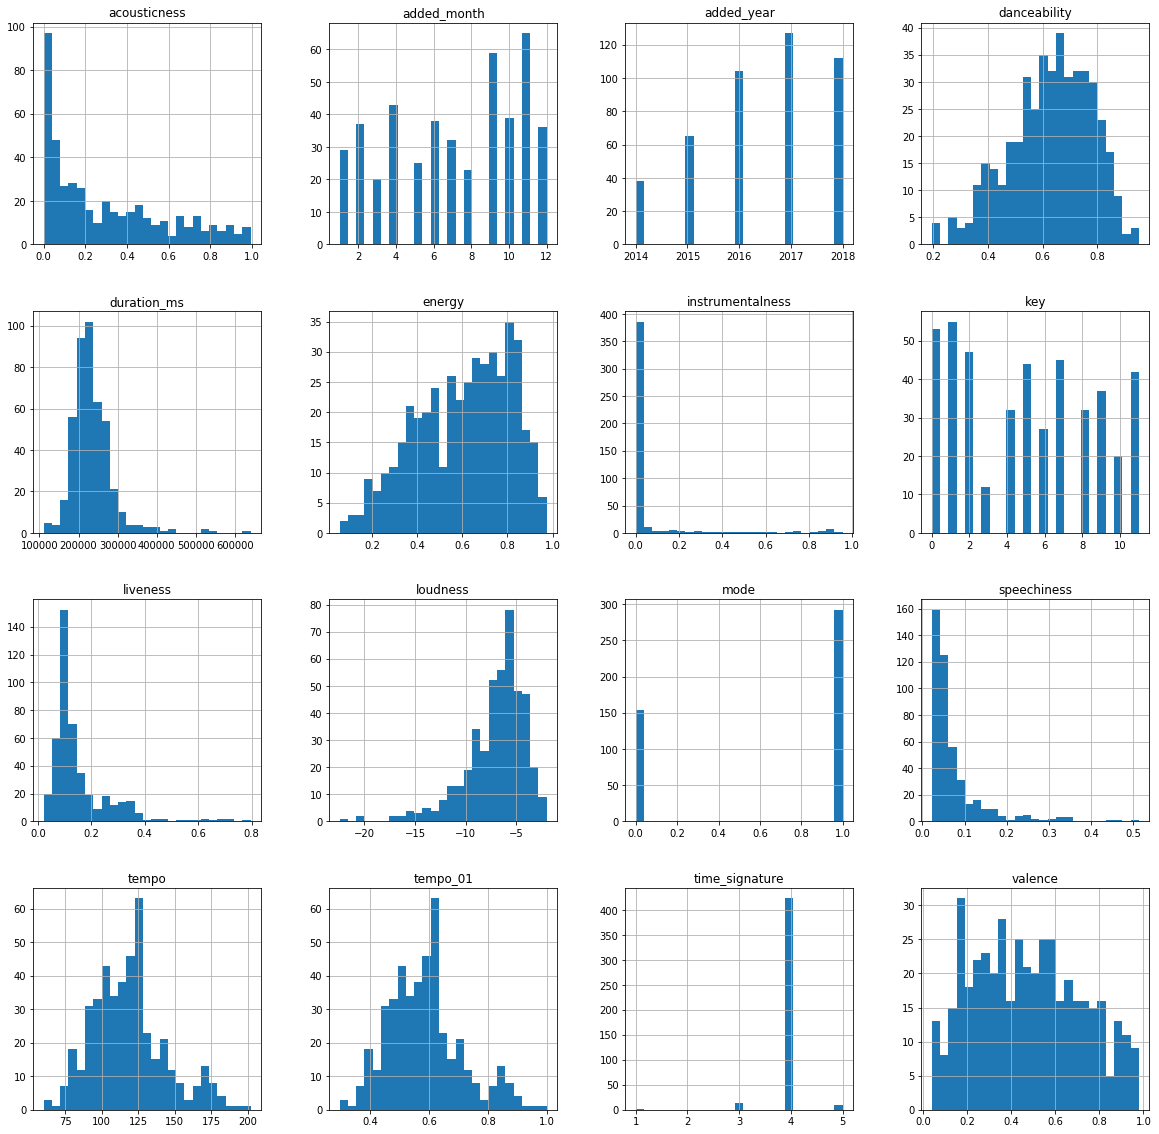

In [6]:
df_saved.hist(figsize=(20,20), bins=25)
plt.show()

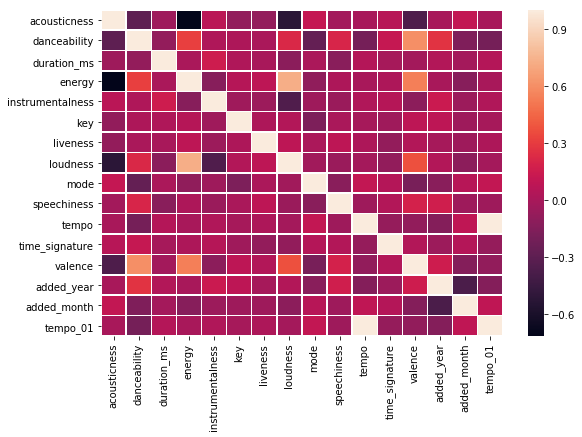

In [7]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_saved.corr(), linewidths=.5, ax=ax)

In [8]:
# add_ym_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'mode', 'tempo_01']
df_add_ym = df_saved.groupby(['added_year','added_month']).mean().reset_index()
df_add_ym = df_add_ym[df_add_ym['added_year'] > 2014]
# df_add_ym['date_grp'] = df_add_ym.apply(lambda row: datetime.date(int(row['added_year']), int(row['added_month']), 1), axis=1)
df_add_ym.head()

,added_year,added_month,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,tempo_01
3,2015,1,0.021433,0.643250,229706.750000,0.742000,0.001026,4.000000,0.131600,-5.847000,1.000000,0.068900,119.491250,4.0,0.628000,0.591239
4,2015,2,0.343633,0.574000,202339.333333,0.575000,0.000022,7.666667,0.141200,-7.214667,0.333333,0.041833,108.213333,4.0,0.494333,0.535437
5,2015,4,0.348386,0.524857,227214.142857,0.636857,0.032892,6.857143,0.121800,-6.747429,1.000000,0.037700,121.472429,4.0,0.286714,0.601042
6,2015,5,0.373795,0.571000,206272.000000,0.557500,0.000000,0.000000,0.132800,-7.135500,1.000000,0.030600,134.428000,4.0,0.400500,0.665146
7,2015,6,0.159285,0.615500,234052.875000,0.744375,0.003026,2.875000,0.292625,-4.877250,0.625000,0.075413,107.985750,4.0,0.456737,0.534310


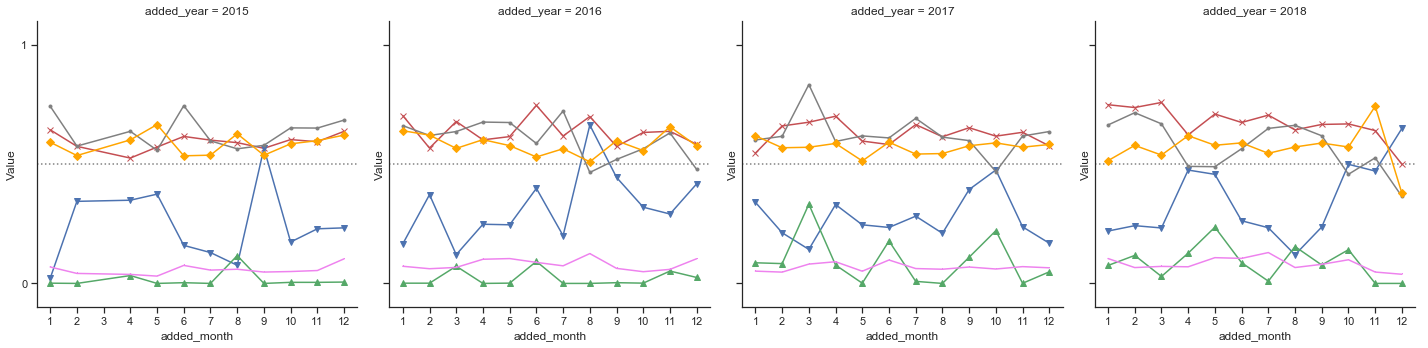

In [23]:
sns.set(style="ticks")
grid = sns.FacetGrid(data=df_add_ym, col="added_year", height=5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0.5, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
# grid.map(plt.plot, "added_month", "energy", marker="o", color='grey')
grid.map(plt.plot, "added_month", "danceability", marker="x", color='r')
grid.map(plt.plot, "added_month", "acousticness", marker="v", color='b')
grid.map(plt.plot, "added_month", "instrumentalness", marker="^", color='g')
grid.map(plt.plot, "added_month", "energy", marker=".", color='grey')
grid.map(plt.plot, "added_month", "tempo_01", marker="D", color='orange')
grid.map(plt.plot, "added_month", "speechiness", marker=",", color='violet')


# Adjust the tick positions and labels
grid.set(xticks=np.arange(13), yticks=[0, 1], 
         xlim=(0.5,12.5), ylim=(-0.1,1.1), 
         ylabel='Value')

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)


plt.show()

In [10]:
df_recent = df_saved[df_saved['added_year'] >= 2017]

In [11]:
df_recent.sample(5)

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,added_at,song_title,artists,added_year,added_month,tempo_01
10,0.2570,0.696,228587,0.955,4tZp15Dj8yJH3lyf0uh2A4,0.001140,9,0.0920,-2.887,1,0.0688,124.010,4,0.689,2017-04-21 13:10:19,Easy Love,Sigala,2017,4,0.613598
8,0.4590,0.598,203546,0.400,0jdeV5dSB3kUBRqe1xQJbh,0.000000,6,0.1510,-10.054,1,0.0241,96.938,4,0.369,2017-02-12 12:26:39,True,Ryan Cabrera,2017,2,0.479647
14,0.4990,0.619,194019,0.574,1L9X1uzSZoPwyVzFOIOKDh,0.000000,7,0.1250,-4.925,1,0.0286,85.843,4,0.383,2018-04-01 05:59:16,Good For You,Eric Nam,2018,4,0.424749
1,0.0884,0.794,234913,0.717,7g82vOTdtPcefFMwtjnyuo,0.000236,2,0.0608,-8.074,1,0.0423,115.033,4,0.769,2018-08-21 08:44:57,Kryptonite,Astronauts,2018,8,0.569180
18,0.0642,0.818,258503,0.858,1NFjjAIK4IWjDLzpMry0Kp,0.256000,1,0.2560,-4.219,0,0.0398,119.605,4,0.753,2017-03-23 03:32:58,Do It,Tuxedo,2017,3,0.591802


In [12]:
cluster_features = ['acousticness', 'danceability', 'instrumentalness', 'energy', 'speechiness','tempo_01']
df_cluster = df_recent[cluster_features]
X = np.array(df_cluster)

In [13]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import metrics

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, max_iter=1000, init='k-means++').fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])


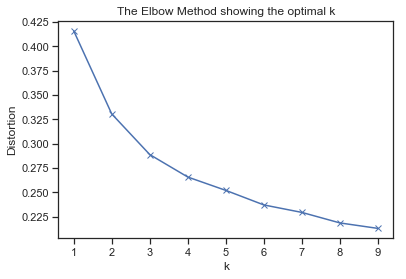

In [14]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [15]:
kmeanModel = KMeans(n_clusters=4, max_iter=1000, init='k-means++').fit(X)

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=123)
pca_results = pca.fit_transform(X)

In [17]:
df_pca = pd.DataFrame(pca_results)
df_pca.columns = ['PC1', 'PC2']
df_pca['label'] = kmeanModel.labels_
df_pca.head()

,PC1,PC2,label
0,0.432765,-0.188869,3
1,0.347532,-0.158665,3
2,-0.029414,-0.065897,1
3,0.682007,-0.226529,3
4,-0.114495,-0.058194,1


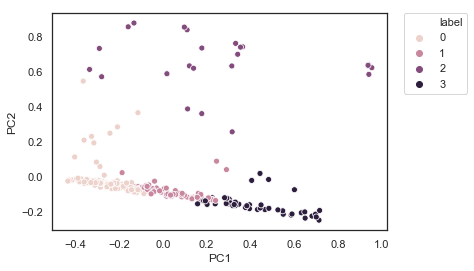

In [18]:
sns.set_style('white')
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, n_iter=5000, random_state=123)
tsne_results = tsne.fit_transform(X)

In [20]:
df_tsne = pd.DataFrame(tsne_results)
df_tsne.columns = ['D1', 'D2']
df_tsne['label'] = kmeanModel.labels_
df_tsne.head()

,D1,D2,label
0,3.859386,-5.069587,3
1,0.773740,-4.233490,3
2,-1.568268,0.825083,1
3,3.356168,-7.710921,3
4,5.222886,4.029545,1


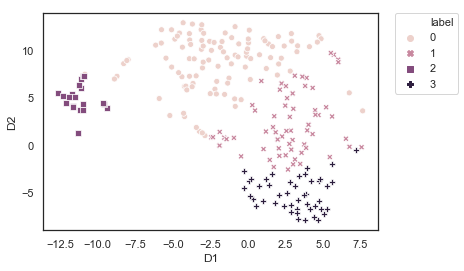

In [21]:
sns.set_style('white')
sns.scatterplot(data=df_tsne, x='D1', y='D2', hue='label', style='label')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [25]:
df_recent.loc[:,'cluster'] = kmeanModel.labels_

C:\Users\john_koh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\john_koh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
df_recent.sample(5)

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,...,tempo,time_signature,valence,added_at,song_title,artists,added_year,added_month,tempo_01,cluster
5,0.03230,0.671,209355,0.859,7b8YOVV5quZcSKEijDgyWB,0.000,4,0.2670,-3.922,0,...,139.931,4,0.389,2018-08-04 04:30:04,DDU-DU DDU-DU,BLACKPINK,2018,8,0.692375,0
19,0.28400,0.667,205660,0.836,5TLAKCWzRqi9AY1NdCe0q0,0.000,4,0.2300,-2.894,1,...,107.984,4,0.891,2018-01-27 03:37:25,Day 1,K.Will,2018,1,0.534302,0
12,0.31900,0.853,242140,0.543,43KGgVeO6p5ICD4auHrpLC,0.000,1,0.0824,-6.526,1,...,99.965,4,0.728,2018-06-05 13:03:40,That Good Ship,"AllttA,20syl,Mr. J. Medeiros",2018,6,0.494624,1
18,0.06370,0.796,258667,0.490,2aRPYQQb6Zeal2LgZGf74f,0.000,6,0.0451,-6.793,1,...,89.949,4,0.921,2018-07-09 12:34:35,黑人問號.jpg,"RPG,NEOSO",2018,7,0.445065,1
4,0.00082,0.802,222400,0.830,0aT3fTNiqk3B3NKEMmNjuL,0.227,9,0.0466,-8.483,1,...,113.947,4,0.767,2018-01-14 08:43:22,Jusagroove,CHIC,2018,1,0.563807,0


In [27]:
#calculate mean of each variable
col_lab = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo_01','cluster']
df_radar = df_recent[col_lab]
df_radar = df_radar.groupby('cluster').mean().reset_index()
# feature_mean= list(df_radar)
# feature_mean
df_radar 

#transpose mean of variables back to original structure
# df_radar = pd.DataFrame(feature_mean).T
# df_radar.columns = col_lab

,cluster,acousticness,danceability,energy,instrumentalness,tempo_01
0,0,0.108303,0.705481,0.772462,0.025484,0.580061
1,1,0.312689,0.692062,0.507141,0.006942,0.559567
2,2,0.374790,0.644261,0.514565,0.774913,0.598143
3,3,0.669652,0.510304,0.395022,0.016282,0.553664


In [28]:
from math import pi

# https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
def make_radar(row, title, color, dframe):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(2,2,row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=7)
    plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

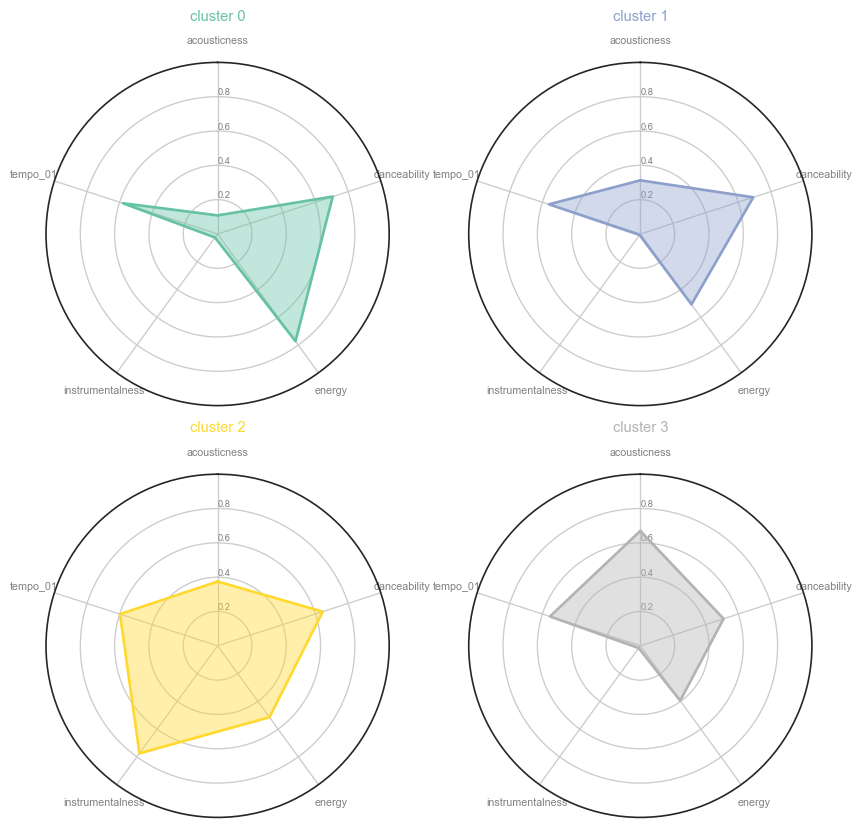

In [29]:
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df_radar.index))
 
# Loop to plot
for row in range(0, len(df_radar.index)):
    make_radar(row=row, title='cluster '+ str(df_radar['cluster'][row]), color=my_palette(row), dframe=df_radar)

In [ ]:
label = kmeanModel.labels_
df_cluster.loc[:,'label'] = label
df_cluster.head()

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_cluster['acousticness'], df_cluster['danceability'], df_cluster['instrumentalness'],
           c=df_cluster['label'], cmap='Set1')

ax.set_xlabel('acousticness')
ax.set_ylabel('danceability')
ax.set_zlabel('instrumentalness')
plt.show()

In [ ]:
from sklearn.svm import OneClassSVM
X = np.array(df_cluster[['acousticness','danceability','instrumentalness']])
svm = OneClassSVM()
svm = svm.fit(X)

In [ ]:
xx, yy = np.meshgrid(np.linspace(-0.1, 1.1, 500), np.linspace(-0.1, 1.1, 500))